# Numerical drifts

Here we read in the network just to do a few, quick calculations of numerical drifts and mutations between parents and children. 

For example, we'd like to know: For parent-child pairs that report languages, what is the average percentage change in the number of languages reported? This will provide evidence of language specialization.

We'd also like to know: What is the characteristic change in length of model card between pareret and child? What is the characteristic frequency of auto-generated model cards?

In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import ast
from itertools import combinations
import matplotlib.pyplot as plt
from ordering_helpers import get_trait_list, get_trait_counter, get_trait_graph, append_total_appearances, get_trait_ratios, get_oriented_trait_graph, get_top_trait_graph, solve_max_compatible_ordering, solve_weighted_compatible_ordering, get_violating_edges, get_compatible_and_total_traffic
import random
import ast

#with open('data/ai_ecosystem_graph_finetune_modelcards.pkl', 'rb') as f:
#    G = pickle.load(f)

with open('data/ai_ecosystem_graph_modelcards.pkl', 'rb') as f:
    G = pickle.load(f)

In [2]:
# Define has_model_card and number_of_languages
count_model_card = 0
for node in G.nodes():
    G.nodes[node]['has_model_card'] = False
    if G.nodes[node]['model_card_length_characters']>3:
        G.nodes[node]['has_model_card'] = True
        count_model_card += 1
    G.nodes[node]['number_of_languages'] = len(get_trait_list(G.nodes[node], 'languages'))
 

In [25]:
print(count_model_card/len(G.nodes()))

0.6703620866571957


In [4]:
# Print a random edge from G
random_edge = random.choice(list(G.edges()))
print(random_edge)
print(G.edges[random_edge])


('FacebookAI/xlm-roberta-large', 'zouharvi/PreCOMET-diffdisc_direct')
{'edge_types': ['finetune'], 'edge_type': 'finetune', 'change_in_likes': -451, 'percentage_change_in_likes': -1.0, 'change_in_downloads': -4152296, 'percentage_change_in_downloads': -0.9999990366784673, 'change_in_createdAt_days': 1046}


In [5]:
edge_list = []
parent = []
child = []
parent_has_model_card = []
child_has_model_card = []
parent_has_auto_generated_model_card = []
child_has_auto_generated_model_card = []
parent_bespoke_card_length = []
child_bespoke_card_length = []
parent_has_languages = []
child_has_languages = []
parent_number_of_languages = []
child_number_of_languages = []
parent_number_of_languages_reporting = []
child_number_of_languages_reporting = []
edge_type = []

count_missing_languages = 0
counter = 0
for edge in G.edges():
    counter += 1
    if counter % 100000 == 0: 
        print(counter)
    edge_type.append(G.edges[edge]['edge_type'])
    parent_has_model_card.append(G.nodes[edge[0]]['has_model_card'])
    child_has_model_card.append(G.nodes[edge[1]]['has_model_card'])
    parent_has_auto_generated_model_card.append(G.nodes[edge[0]]['model_card_automatically_generated'])
    child_has_auto_generated_model_card.append(G.nodes[edge[1]]['model_card_automatically_generated'])
    #if G.nodes[edge[0]]['model_card_automatically_generated']==False and G.nodes[edge[1]]['model_card_automatically_generated']==False and G.nodes[edge[0]]['has_model_card']==True and G.nodes[edge[1]]['has_model_card']==True:
    if  G.nodes[edge[0]]['has_model_card']==True and G.nodes[edge[1]]['has_model_card']==True:
        parent_bespoke_card_length.append(G.nodes[edge[0]]['model_card_length_characters'])
        child_bespoke_card_length.append(G.nodes[edge[1]]['model_card_length_characters'])
    else:
        parent_bespoke_card_length.append(None)
        child_bespoke_card_length.append(None)

    parent_has_languages.append(len(get_trait_list(G.nodes[edge[0]], 'languages'))>0)
    child_has_languages.append(len(get_trait_list(G.nodes[edge[1]], 'languages'))>0)
    parent_number_of_languages.append(len(get_trait_list(G.nodes[edge[0]], 'languages')))
    child_number_of_languages.append(len(get_trait_list(G.nodes[edge[1]], 'languages')))
    if G.nodes[edge[0]]['languages']!='[]' and G.nodes[edge[1]]['languages']!='[]':
        parent_number_of_languages_reporting.append(len(get_trait_list(G.nodes[edge[0]], 'languages')))
        child_number_of_languages_reporting.append(len(get_trait_list(G.nodes[edge[1]], 'languages')))
    else:
        parent_number_of_languages_reporting.append(None)
        child_number_of_languages_reporting.append(None)
    parent.append(edge[0])
    child.append(edge[1])


result_df = pd.DataFrame(columns = ['parent'
                                    , 'child'
                                    , 'edge_type'
                                    , 'parent_has_model_card'
                                    , 'child_has_model_card'
                                    , 'parent_has_auto_generated_model_card'
                                    , 'child_has_auto_generated_model_card'
                                    , 'parent_bespoke_card_length'
                                    , 'child_bespoke_card_length'
                                    , 'parent_has_languages'
                                    , 'child_has_languages'
                                    , 'parent_number_of_languages'
                                    , 'child_number_of_languages'
                                    , 'parent_number_of_languages_reporting'
                                    , 'child_number_of_languages_reporting'
                                    ])
# Append the lists to the dataframe
result_df['parent'] = parent
result_df['child'] = child
result_df['edge_type'] = edge_type
result_df['parent_has_model_card'] = parent_has_model_card
result_df['child_has_model_card'] = child_has_model_card
result_df['parent_has_auto_generated_model_card'] = parent_has_auto_generated_model_card
result_df['child_has_auto_generated_model_card'] = child_has_auto_generated_model_card
result_df['parent_bespoke_card_length'] = parent_bespoke_card_length
result_df['child_bespoke_card_length'] = child_bespoke_card_length
result_df['parent_has_languages'] = parent_has_languages
result_df['child_has_languages'] = child_has_languages
result_df['parent_number_of_languages'] = parent_number_of_languages
result_df['child_number_of_languages'] = child_number_of_languages
result_df['parent_number_of_languages_reporting'] = parent_number_of_languages_reporting
result_df['child_number_of_languages_reporting'] = child_number_of_languages_reporting

100000
200000
300000
400000
500000


In [6]:
result_df['child_has_model_card'].value_counts()

child_has_model_card
True     571227
False      2426
Name: count, dtype: int64

558385
558942


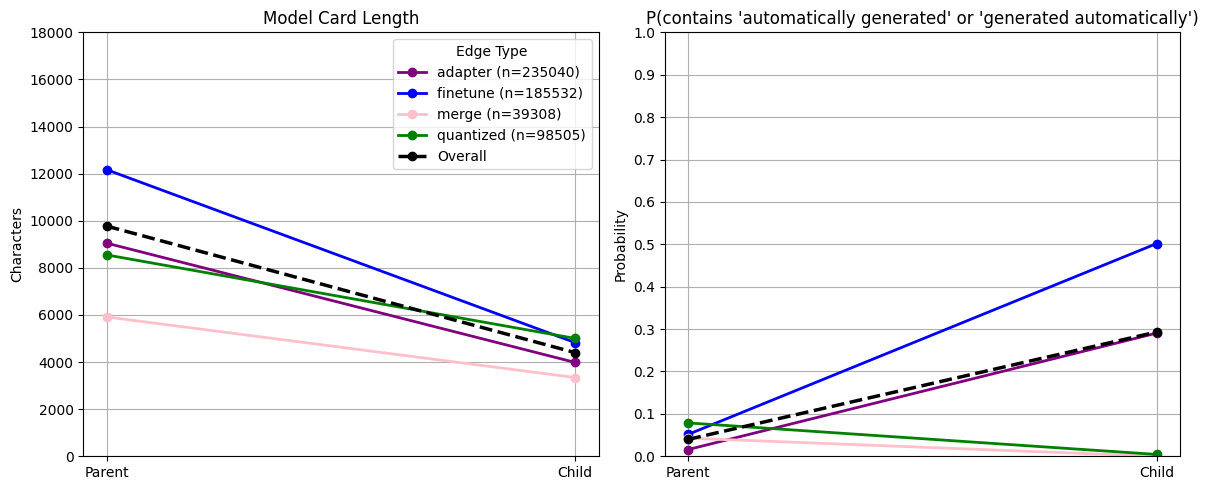

In [17]:
filtered_df = result_df[['edge_type','parent_bespoke_card_length','child_bespoke_card_length']].dropna()
print(len(filtered_df))

# Create a side-by-side subplot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Compute and plot the mean line for each edge type
edge_colors = {}
for i, edge_type in enumerate(filtered_df['edge_type'].unique()):
    if edge_type == 'finetune':
        edge_colors[edge_type] = 'blue'
    elif edge_type == 'merge':
        edge_colors[edge_type] = 'pink'
    elif edge_type == 'quantized':
        edge_colors[edge_type] = 'green'
    elif edge_type == 'adapter':
        edge_colors[edge_type] = 'purple'

for edge_type, group in filtered_df.groupby('edge_type'):
    mean_parent = group['parent_bespoke_card_length'].mean()
    mean_child = group['child_bespoke_card_length'].mean()
    axes[0].plot(['Parent', 'Child'],
            [mean_parent, mean_child],
            linewidth=2, label=f'{edge_type} (n={len(group)})', color=edge_colors[edge_type], marker='o')

mean_parent = result_df['parent_bespoke_card_length'].mean()
mean_child = result_df['child_bespoke_card_length'].mean()
axes[0].plot(['Parent', 'Child'],
             [mean_parent, mean_child],
             linewidth=2.5, label='Overall', color='black', marker='o', linestyle='--')

             
# Update legend to include edge types
axes[0].legend(title='Edge Type')
axes[0].set_ylim(0,18000)
axes[0].set_title("Model Card Length")
axes[0].set_ylabel("Characters")
axes[0].grid(True)

# Plot the first figure (Card contains 'automatically generated' or 'generated automatically')
filtered_df_auto_generated = result_df[(result_df['parent_has_model_card']==True)&(result_df['child_has_model_card']==True)].dropna(subset=['parent_has_auto_generated_model_card', 'child_has_auto_generated_model_card'])
print(len(filtered_df_auto_generated))
edge_colors_auto_generated = {'finetune': 'blue', 'merge': 'pink', 'quantized': 'green', 'adapter': 'purple'}

for edge_type, group in filtered_df_auto_generated.groupby('edge_type'):
    mean_parent_auto_generated = group['parent_has_auto_generated_model_card'].mean()
    mean_child_auto_generated = group['child_has_auto_generated_model_card'].mean()
    axes[1].plot(['Parent', 'Child'],
                 [mean_parent_auto_generated, mean_child_auto_generated],
                 linewidth=2, label=f'{edge_type} (n={len(group)})', color=edge_colors_auto_generated[edge_type], marker='o')

# Plot the overall means without grouping
mean_parent_auto_generated = result_df['parent_has_auto_generated_model_card'].mean()
mean_child_auto_generated = result_df['child_has_auto_generated_model_card'].mean()
axes[1].plot(['Parent', 'Child'],
             [mean_parent_auto_generated, mean_child_auto_generated],
             linewidth=2.5, label='Overall', color='black', marker='o', linestyle='--')

#axes[1].legend(title='Edge Type')
axes[1].set_ylim(0, 1)
axes[1].set_yticks([i * 0.1 for i in range(11)])
axes[1].set_title("P(contains 'automatically generated' or 'generated automatically')")
axes[1].set_ylabel("Probability")
axes[1].grid(True)

plt.tight_layout()
plt.savefig('figures/model_card_length_and_auto_generated.png', dpi=350, bbox_inches='tight')
plt.show()


24K
23728
47K
47369
3K
3299
41K
41222


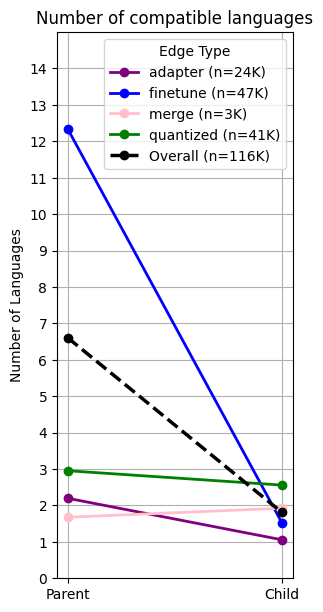

In [24]:
import matplotlib.pyplot as plt

# Filter out any rows with missing number of languages reporting
filtered_df_languages = result_df.dropna(subset=['parent_number_of_languages_reporting', 'child_number_of_languages_reporting'])

# Create figure and axis
fig, ax = plt.subplots(figsize=(3, 6))

# Compute and plot the mean line for each edge type
edge_colors_languages = {}
for i, edge_type in enumerate(filtered_df_languages['edge_type'].unique()):
    if edge_type == 'finetune':
        edge_colors_languages[edge_type] = 'blue'
    elif edge_type == 'merge':
        edge_colors_languages[edge_type] = 'pink'
    elif edge_type == 'quantized':
        edge_colors_languages[edge_type] = 'green'
    elif edge_type == 'adapter':
        edge_colors_languages[edge_type] = 'purple'

for edge_type, group in filtered_df_languages.groupby('edge_type'):
    mean_parent_languages = group['parent_number_of_languages_reporting'].mean()
    mean_child_languages = group['child_number_of_languages_reporting'].mean()
    n_rounded = round(len(group), -3)
    n_display = f"{n_rounded // 1000}K"
    ax.plot(['Parent', 'Child'],
            [mean_parent_languages, mean_child_languages],
            linewidth=2, label=f'{edge_type} (n={n_display})', color=edge_colors_languages[edge_type], marker='o')
    
    print(n_display)
    print(len(group))

# Plot the overall means without grouping
mean_parent_languages = filtered_df_languages['parent_number_of_languages_reporting'].mean()
mean_child_languages = filtered_df_languages['child_number_of_languages_reporting'].mean()
n_all = len(filtered_df_languages)
n_all_rounded = round(n_all, -3)
n_all_display = f"{n_all_rounded // 1000}K"
ax.plot(['Parent', 'Child'],
             [mean_parent_languages, mean_child_languages],
             linewidth=2.5, label=f'Overall (n={n_all_display})', color='black', marker='o', linestyle='--')


# Update legend to include edge types
ax.legend(title='Edge Type')

plt.ylim(0, 15)  # Assuming the number of languages is between 0 and 10
plt.yticks(range(15))
plt.tight_layout()
plt.title("Number of compatible languages")
plt.ylabel("Number of Languages")
plt.grid(True)
plt.savefig('figures/number_of_compatible_languages.png', dpi=350, bbox_inches='tight')
plt.show()


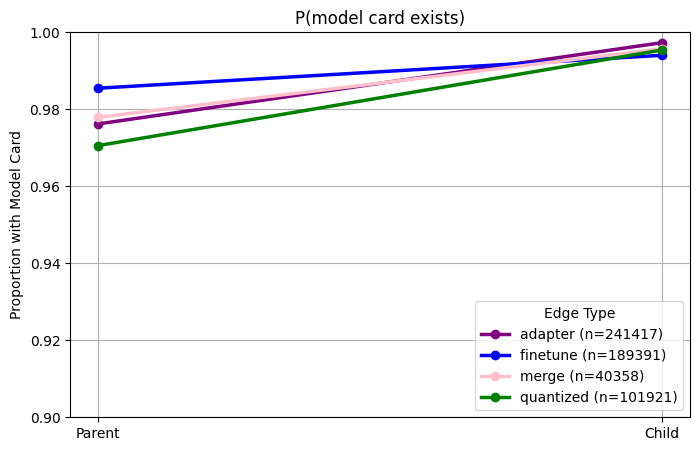

In [9]:
# Create a new subplot for the mean has_model_card change
fig, ax = plt.subplots(figsize=(8, 5))

# Compute and plot the mean line for each edge type
for edge_type, group in result_df.groupby('edge_type'):
    mean_parent_has_model_card = group['parent_has_model_card'].mean()
    mean_child_has_model_card = group['child_has_model_card'].mean()
    ax.plot(['Parent', 'Child'],
            [mean_parent_has_model_card, mean_child_has_model_card],
            linewidth=2.5, label=f'{edge_type} (n={len(group)})', color=edge_colors[edge_type], marker='o')

# Update legend to include edge types
ax.legend(title='Edge Type',loc='lower right')
ax.set_ylim(.9, 1)
ax.set_title("P(model card exists)")
ax.set_ylabel("Proportion with Model Card")
ax.grid(True)

plt.show()

In [10]:
print("Change in probability of having a model card: ")
print(np.mean(result_df['child_has_model_card'].astype(int))-np.mean(result_df['parent_has_model_card'].astype(int)))
print()

print("Change in probability of having an auto-generated model card | parent and child have model card: ")
print(np.mean(result_df[(result_df['parent_has_model_card']==1)&(result_df['child_has_model_card']==1)]['child_has_auto_generated_model_card'].astype(int))-np.mean(result_df[(result_df['parent_has_model_card']==1)&(result_df['child_has_model_card']==1)]['parent_has_auto_generated_model_card'].astype(int)))
print()

print("Change in probability of having an auto-generated model card: ")
print(np.mean(result_df['child_has_auto_generated_model_card'].astype(int))-np.mean(result_df['parent_has_auto_generated_model_card'].astype(int)))
print()

result_df['card_length_change'] = result_df.apply(
    lambda row: row['child_bespoke_card_length'] - row['parent_bespoke_card_length']
    if pd.notna(row['child_bespoke_card_length']) and pd.notna(row['parent_bespoke_card_length'])
    else np.nan,
    axis=1
)

result_df['card_length_increase_flag'] = result_df.apply(
    lambda row: row['child_bespoke_card_length'] > row['parent_bespoke_card_length']
    if pd.notna(row['child_bespoke_card_length']) and pd.notna(row['parent_bespoke_card_length'])
    else np.nan,
    axis=1
)

#result_df['card_length_increase_flag'] = result_df['card_length_change'] > 0 if result_df['card_length_change'].isna()==False else None
#print(result_df['card_length_increase_flag'].value_counts())
#print(result_df['card_length_increase_flag'].value_counts(normalize=True))

#print("Change in probability of having a bespoke model card: ")
#print(np.mean(result_df['parent_bespoke_card_length'].astype(int))-np.mean(result_df['child_bespoke_card_length'].astype(int)))
#print()




Change in probability of having a model card: 
0.017376358181688145

Change in probability of having an auto-generated model card | parent and child have model card: 
0.24868054288280356

Change in probability of having an auto-generated model card: 
0.2531983620760285



In [11]:
print("Mean parent card length: ", np.mean(result_df['parent_bespoke_card_length']))
print("Mean child card length: ", np.mean(result_df['child_bespoke_card_length']))
print("Mean card length change: ", np.mean(result_df['card_length_change']))
print("Mean parent number of languages: ", np.mean(result_df['parent_number_of_languages']))
print("Mean child number of languages: ", np.mean(result_df['child_number_of_languages']))
print("Mean parent number of languages reporting: ", np.mean(result_df['parent_number_of_languages_reporting']))
print("Mean child number of languages reporting: ", np.mean(result_df['child_number_of_languages_reporting']))

Mean parent card length:  9773.375631103048
Mean child card length:  4401.633665031434
Mean card length change:  -5371.741966071614
Mean parent number of languages:  4.177246523595275
Mean child number of languages:  0.4520014712727032
Mean parent number of languages reporting:  6.604478644302265
Mean child number of languages reporting:  1.81028877745115


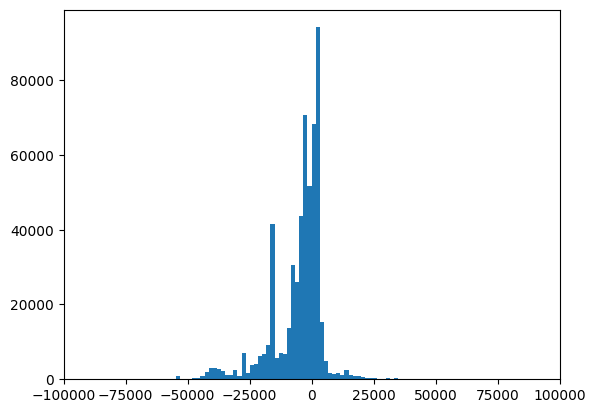

In [12]:
plt.hist(result_df['card_length_change'], bins = 1000)
plt.xlim(-100000,100000)
plt.show()